Проект посвящен задаче классификации аудио

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torchaudio
from IPython import display
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset

%matplotlib inline

device = "cuda:0"

# Классификация аудиозаписей.

Будем классифицировать данные из датасета[UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html).

Данный датасет состоит из 8732 записей, разбитых на train/val/test датасеты.

![image](https://paperswithcode.com/media/datasets/UrbanSound8K-0000003722-02faef06.jpg)

Каждая аудиозапись содержит запись шума города и принадлежит одному из 10 классов:

`[air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music]`


Подготовим данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


- Напишем `AudioDataset` класс, который будет принимать путь к файлам `train_part.csv` и `val_part.csv` и возращать тройки объектов `(x, y, len)`, где `x` - аудиозапись, `y` - класс аудиозаписи, `len` - длина аудиозаписи. Аудиозаписи, подгрузку _wav_ файлов надо сделать при запросе через `__getitem__` метод. Кроме того, надо сделать паддинг аудиозаписи - если она короче чем `pad_size` параметр, надо дополнять ее нулями.

In [ ]:
!rm -r ./data
!mkdir ./data/
!pip install gdown
!cd ./data && gdown --id '1057RRnXefWOCvpzjSnRA-Xl-O3NnX8Vq' && unzip HW2_dataset

rm: cannot remove './data': No such file or directory
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1057RRnXefWOCvpzjSnRA-Xl-O3NnX8Vq

but Gdown can't. Please check connections and permissions.


In [ ]:
!unzip HW2_dataset

unzip:  cannot find or open HW2_dataset, HW2_dataset.zip or HW2_dataset.ZIP.


In [ ]:
# классы данных
classes = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music",
]

In [ ]:
class AudioDataset(Dataset):
    def __init__(
        self,
        path_to_csv: str,
        path_to_folder: str,
        pad_size: int = 384000,
        sr: int = 44100,
    ):
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)[["ID", "Class"]]
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size

        self.sr = sr

        self.class_to_idx = {classes[i]: i for i in range(10)}

    def __getitem__(self, index: int):

        out = self.csv.iloc[index]["ID"]

        w, sr = torchaudio.load(f"{self.path_to_folder}/{out}.wav")
        if sr != self.sr:
            change_sample = torchaudio.transform.Resample(sr, self.sr)
            w = change_sample(w)

        x = torch.zeros(self.pad_size, dtype=torch.float32)
        x[:len(w[0])] = w[0]

        return {"x": x, "y": self.class_to_idx[self.csv.iloc[index]["Class"]], "len": len(w[0])}

    def __len__(self):
        return self.csv.shape[0]

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/HW2_dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: urbansound8k/data/712.wav  
  inflating: urbansound8k/data/1286.wav  
  inflating: urbansound8k/data/7768.wav  
  inflating: urbansound8k/data/855.wav  
  inflating: urbansound8k/data/1319.wav  
  inflating: urbansound8k/data/15.wav  
  inflating: urbansound8k/data/2610.wav  
  inflating: urbansound8k/data/3268.wav  
  inflating: urbansound8k/data/5619.wav  
  inflating: urbansound8k/data/6310.wav  
  inflating: urbansound8k/data/6304.wav  
  inflating: urbansound8k/data/4513.wav  
  inflating: urbansound8k/data/2162.wav  
  inflating: urbansound8k/data/2604.wav  
  inflating: urbansound8k/data/841.wav  
  inflating: urbansound8k/data/699.wav  
  inflating: urbansound8k/data/6462.wav  
  inflating: urbansound8k/data/869.wav  
  inflating: urbansound8k/data/8467.wav  
  inflating: urbansound8k/data/7754.wav  
  inflating: urbansound8k/data/7032.wav  
  inflating: urbansound8k/data/3254.wav  
  inflating: urbansound8k/data/5

In [ ]:
# создадим датасеты
train_dataset = AudioDataset(
    "/content/urbansound8k/train_part.csv", "/content/urbansound8k/data"
)
val_dataset = AudioDataset(
    "/content/urbansound8k/val_part.csv", "/content/urbansound8k/data"
)

In [ ]:
# проверим размеры датасетов
assert len(train_dataset) == 4500
assert len(val_dataset) == 935

In [ ]:
# проверим возращаемые значения __getitem__
item = train_dataset.__getitem__(0)

assert item["x"].shape == (384000,)
assert item["y"] == 0
assert item["len"] == 176400

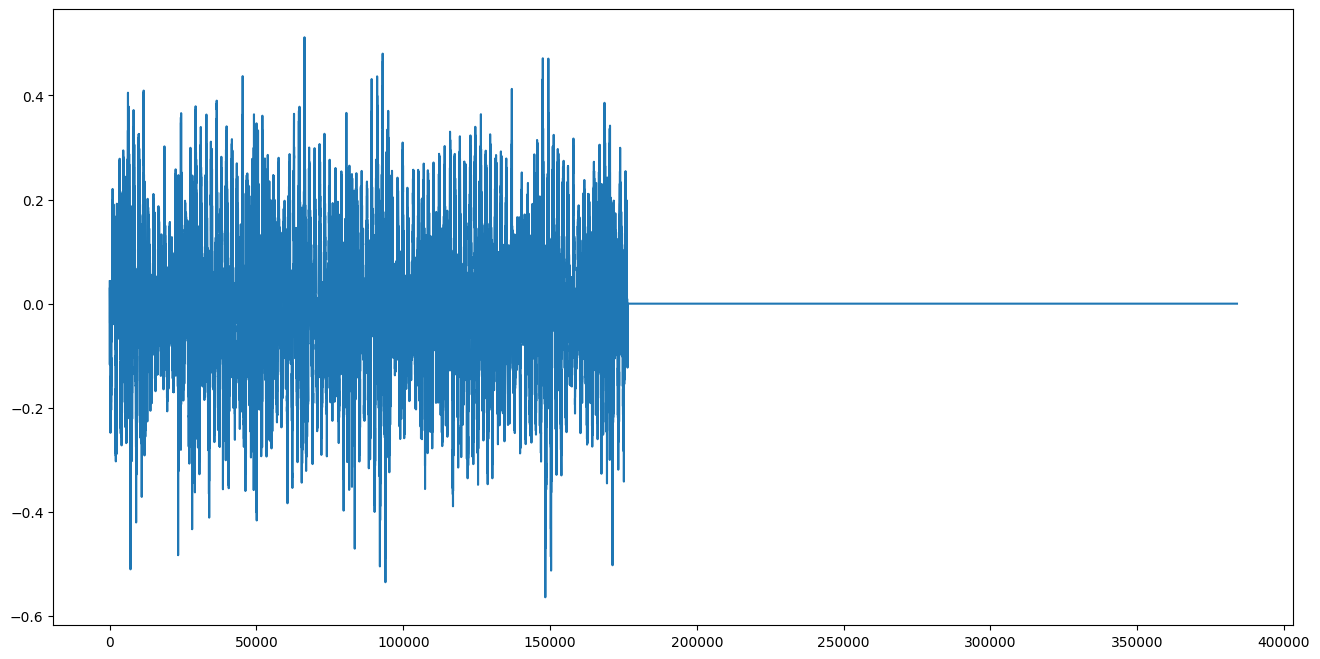

In [ ]:
# нарисуем и проиграем аудиозаписить
item = train_dataset.__getitem__(0)
plt.figure(figsize=(16, 8))
plt.plot(item["x"])

display.Audio(item["x"], rate=train_dataset.sr)

In [ ]:
# создадим даталоадеры
train_dataloader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, pin_memory=True, drop_last=True
)
val_dataloader = DataLoader(val_dataset, batch_size=32, pin_memory=True)

Сделаем RNN

In [ ]:
class RecurrentRawAudioClassifier(nn.Module):
    def __init__(
        self,
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2,
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length

        self.first_mlp = nn.Sequential(
            nn.Linear(1024, 256),
            nn.BatchNorm1d(1497),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(1497),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.BatchNorm1d(1497),
            nn.ReLU()
        )

        self.rnn = nn.LSTM(16, hidden, bidirectional=True, num_layers=num_layers, batch_first=True)

        self.final_mlp = nn.Sequential(
            nn.Linear(2 * hidden * num_layers, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )



    def forward(self, x, lens) -> torch.Tensor:
        batch_windows = x.unfold(1, self.window_length, self.hop_length)
        batch_windows_feautures = self.first_mlp(batch_windows)
        output, (h, c) = self.rnn(batch_windows_feautures)
        hidden_flattened = torch.cat([h[0], h[1], h[2], h[3]], 1)

        return self.final_mlp(hidden_flattened)

Обучим получившуюся модель.

In [ ]:
def train_audio_clfr(
    model,
    optimizer,
    train_dataloader,
    sr,
    criterion=torch.nn.CrossEntropyLoss(),
    data_transform=None,
    augmentation=None,
    num_epochs=10,
    device="cuda:0",
    verbose_num_iters=10,
):
    model.train()
    iter_i = 0

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        for batch in train_dataloader:
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            lens = batch["len"].to(device)

            # применяем преобразование входных данных
            if data_transform:
                x, lens = data_transform(x, lens, device=device, sr=sr)

            # примеменяем к логмелспектрограмме аугментацию
            if augmentation:
                x, lens = augmentation(x, lens)

            probs = model(x, lens)
            optimizer.zero_grad()
            loss = criterion(probs, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            # считаем точность предсказания
            pred_cls = probs.argmax(dim=-1)
            train_accuracies.append((pred_cls == y).float().mean().item())

            iter_i += 1

            # раз в verbose_num_iters визуализируем наши лоссы и семплы
            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)

                print(f"Epoch {epoch}")

                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.xlabel("Iteration")
                plt.ylabel("Train loss")
                plt.plot(np.arange(iter_i), train_losses)

                plt.subplot(1, 2, 2)
                plt.xlabel("Iteration")
                plt.ylabel("Train acc")
                plt.plot(np.arange(iter_i), train_accuracies)

                plt.show()

    model.eval()

In [ ]:
# создадим объекты модели и оптимизатор
rnn_raw = RecurrentRawAudioClassifier()
rnn_raw.to(device)
optim = torch.optim.Adam(rnn_raw.parameters(), lr=3e-4)

Epoch 9


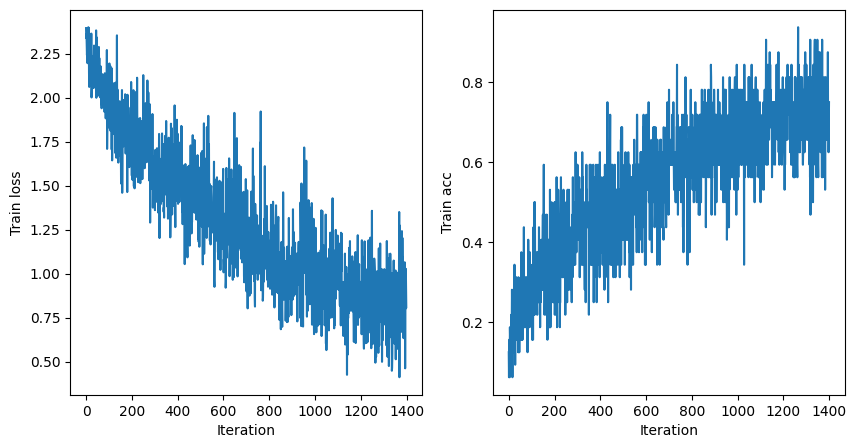

In [ ]:
# обучим модель
train_audio_clfr(rnn_raw, optim, train_dataloader, train_dataset.sr)

Посчитаем метрики на валидационном датасете.

In [ ]:
def plot_confusion_matrix(model, val_dataloader, sr, device, data_transform=None):
    pred_true_pairs = []
    for batch in val_dataloader:
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        lens = batch["len"].to(device)

        with torch.no_grad():
            if data_transform:
                x, lens = data_transform(x, lens, sr=sr, device=device)

            probs = model(x, lens)

            pred_cls = probs.argmax(dim=-1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
            pred_true_pairs.append((pred, true))

    print(f"Val accuracy: {np.mean([p[0] == p[1] for p in pred_true_pairs])}")

    cm_df = pd.DataFrame(
        confusion_matrix(
            [p[1] for p in pred_true_pairs],
            [p[0] for p in pred_true_pairs],
            normalize="true",
        ),
        columns=classes,
        index=classes,
    )
    sn.heatmap(cm_df, annot=True)

Val accuracy: 0.36363636363636365


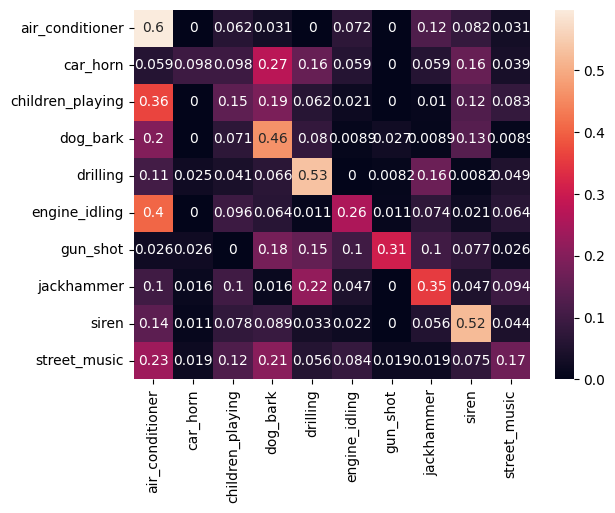

In [ ]:
plot_confusion_matrix(rnn_raw, val_dataloader, train_dataset.sr, device)

Данные еще сырые, много разных шумов, поэтому модель плохо выяснила зависимости

Строим mel spectrograms

In [ ]:
from torchaudio.transforms import MelSpectrogram

# референсная функця
def compute_log_melspectrogram_reference(wav_batch, lens, sr, device="cpu"):
    featurizer = MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,
        win_length=1024,
        hop_length=256,
        n_mels=64,
        center=False,
    ).to(device)

    return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256

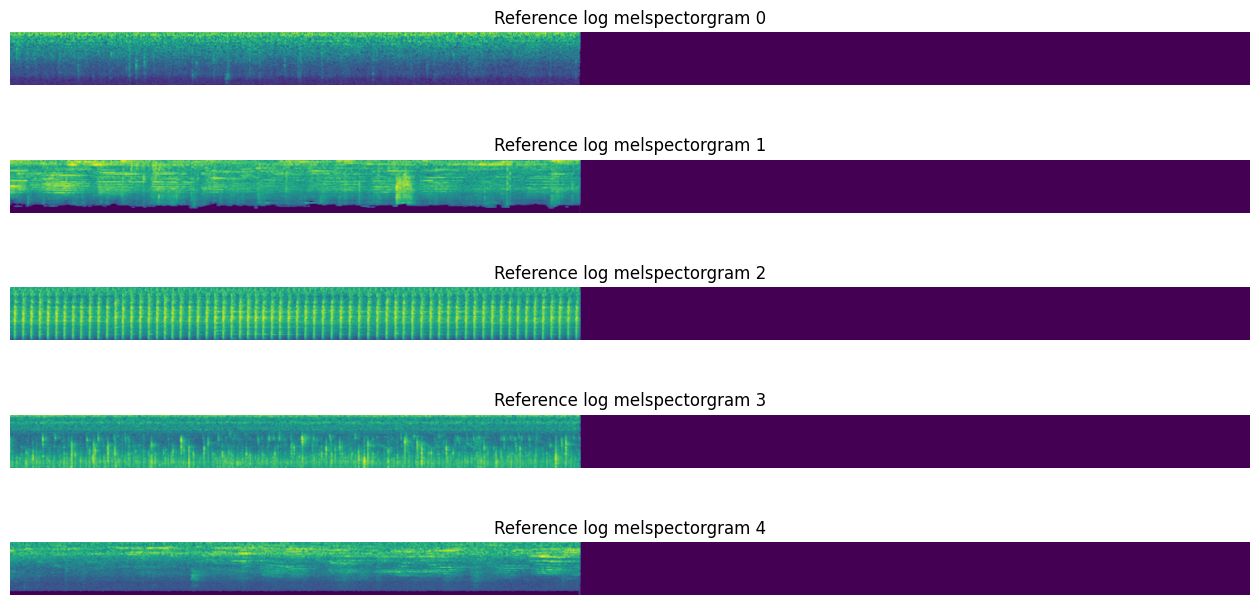

In [ ]:
# возьмем случайный батч
for batch in train_dataloader:
    break

wav_batch = batch["x"]
lens = batch["len"]

# посчитаем лог мелспектрограммы
log_melspect, lens = compute_log_melspectrogram_reference(
    wav_batch, lens, train_dataset.sr
)

# нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Reference log melspectorgram {i}")
    axes[i].imshow(log_melspect[i].numpy())

In [ ]:
sr = train_dataset.sr
n_fft = 1024
win_length = 1024
hop_length = 256
n_mels = 64

In [ ]:
windows = batch['x'].unfold(1, win_length, hop_length)
assert windows.shape == (32, 1497, 1024)

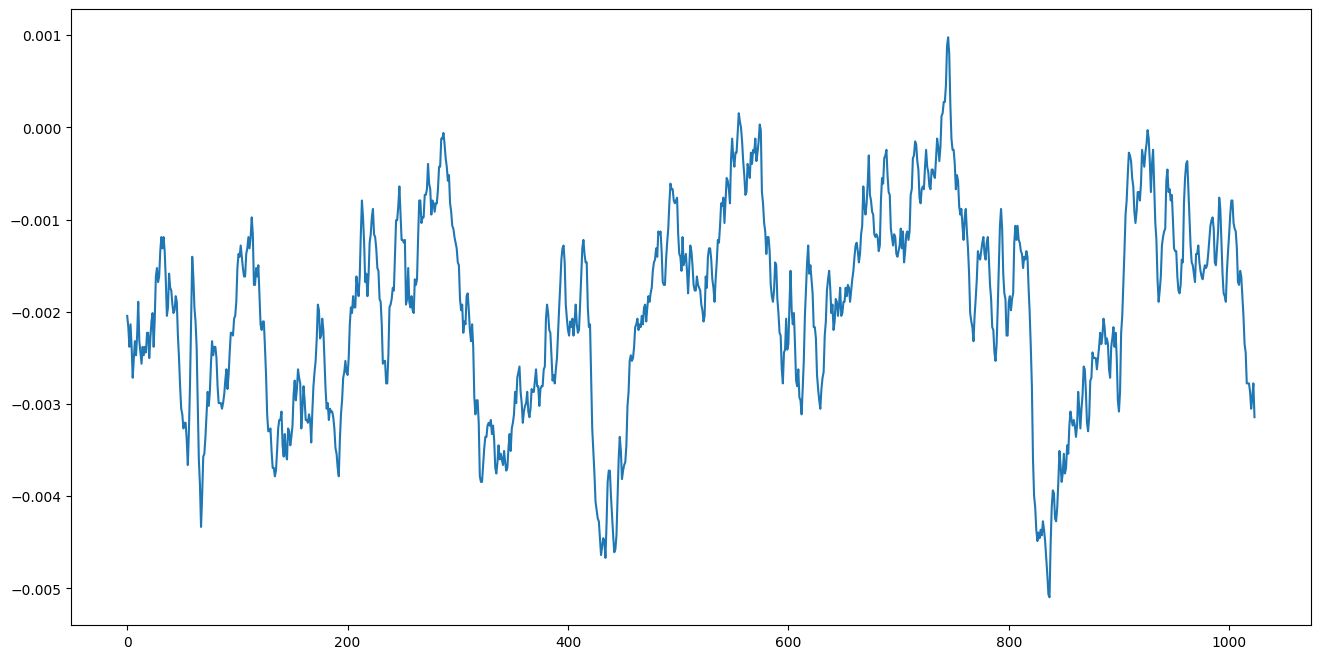

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(windows[0, 0])

display.Audio(windows[0, 0], rate=train_dataset.sr)

Применим косинуисальный фильтр к сигналу из окна. Для этого с помощью `torch.hann_window` создадим косинусоидальный фильтр и умножим его поэлементно на все окна.

In [ ]:
filter = torch.hann_window(win_length)
windows_with_applied_filter = windows * filter[None, None, :]

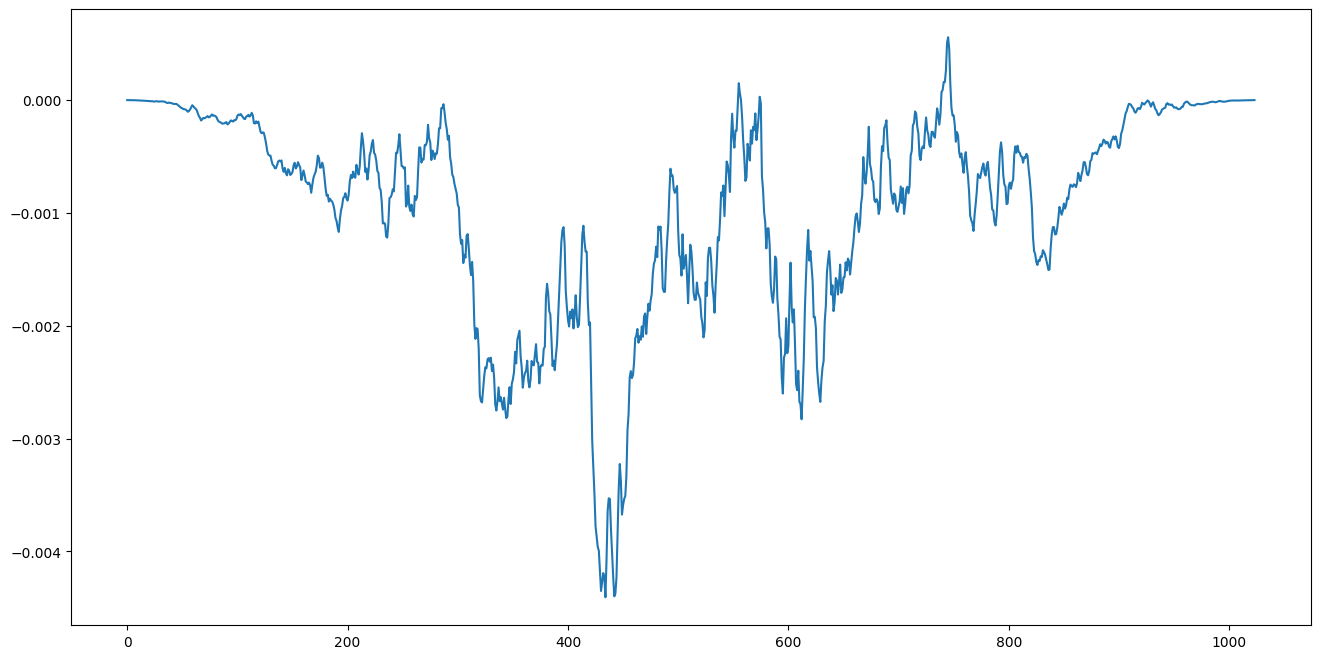

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(windows_with_applied_filter[0, 0])

display.Audio(windows_with_applied_filter[0, 0], rate=train_dataset.sr)

Применим дискретное преобразование Фурье

In [ ]:
fft_features = torch.fft.fft(windows_with_applied_filter)[:, :, :n_fft // 2 + 1]
fft_magnitudes = torch.abs(fft_features**2)
assert fft_magnitudes.shape == (32, 1497, 513)

Через `torchaudio.transforms.MelScale` создадим класс для перевода магнитуд в Мел-шкалу.

In [ ]:
melscale = torchaudio.transforms.MelScale(n_mels = n_mels, sample_rate = sr, n_stft  = 1 + n_fft // 2)

Нелинейное преобразование для перевода в Мел-шкалу выглядит следующим образом.

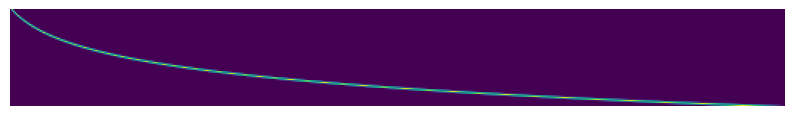

In [ ]:
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.imshow(melscale.fb.numpy().transpose())

Применим Мел-шкалу к магнитудам.

In [ ]:
mel_spectrogram = melscale(torch.transpose(fft_magnitudes, 2, 1))
assert mel_spectrogram.shape == (32, 64, 1497)

Сделаем обрезку значений по `1e-5` и примените `torch.log` для получения логарифмированной Мел-спектрограммы.

In [ ]:
logmel_spectrogram = torch.log(mel_spectrogram.clamp_(1e-5))
assert logmel_spectrogram.shape == (32, 64, 1497)

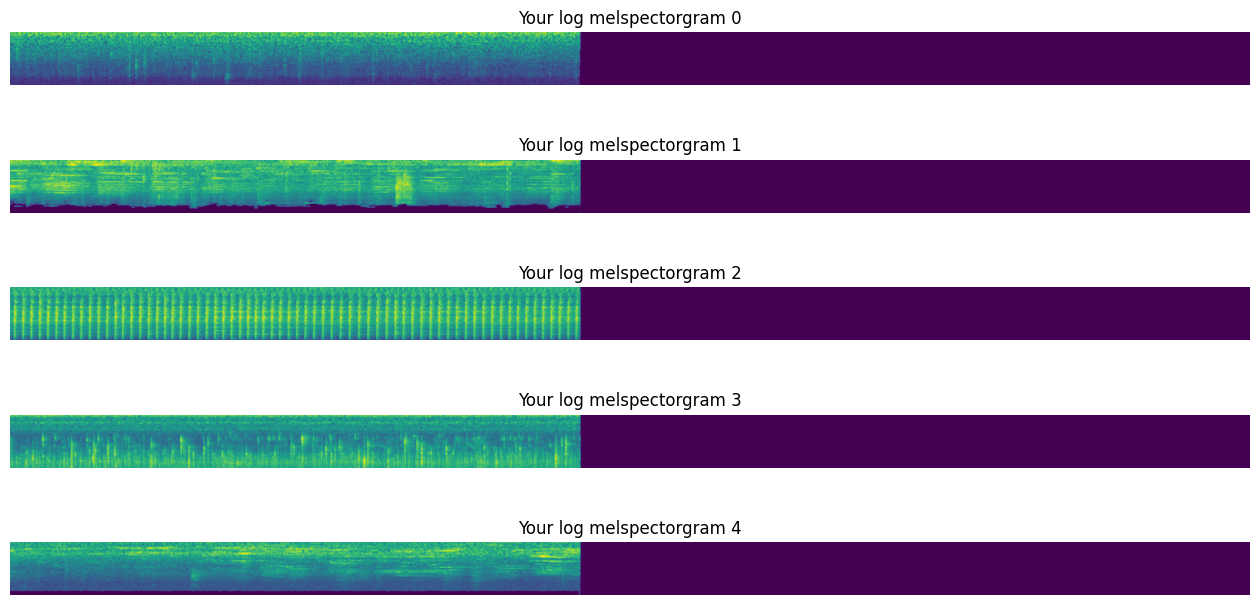

In [ ]:
# нарисуем получившиеся значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Your log melspectorgram {i}")
    axes[i].imshow(logmel_spectrogram[i].numpy())

Теперь оформим эту логику в функцию.

In [ ]:
def compute_log_melspectrogram(wav_batch, lens, sr, device="cpu"):
    wav_batch = wav_batch.to(device)
    windows = wav_batch.unfold(1, win_length, hop_length)
    filter = torch.hann_window(win_length).to(device)
    windows_with_filter = windows * filter[None, None, :]

    fft_magnitudes = torch.abs(torch.fft.fft(windows_with_filter)[:, :, :n_fft // 2 + 1] * torch.fft.fft(windows_with_filter)[:, :, :n_fft // 2 + 1]).to(device)

    melscale = torchaudio.transforms.MelScale(n_mels = n_mels, sample_rate = sr, n_stft  = n_fft // 2 + 1).to(device)

    mel_spectrogram = melscale(torch.transpose(fft_magnitudes, 2, 1).to(device))
    logmel_spectrogram = torch.log(mel_spectrogram.clamp_(1e-5)).to(device)

    return logmel_spectrogram, lens // 256

Финальная проверка.

In [ ]:
assert torch.allclose(
    compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)[0],
    compute_log_melspectrogram(wav_batch, lens, train_dataset.sr)[0],
    atol=1e-5,
)



<center>
<img src="https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2020-2023/2022/hw/hw2/imgs/rnn_mel.png" height="500">
</center>


In [ ]:
class RecurrentMelSpectClassifier(nn.Module):
    def __init__(
        self,
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2,
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length

        self.rnn = nn.LSTM(64, hidden, bidirectional=True, num_layers=num_layers, batch_first=True)

        self.final_mlp = nn.Sequential(
            nn.Linear(2 * hidden * num_layers, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )


    def forward(self, x, lens):
        output, (h, c) = self.rnn(torch.transpose(x, 2, 1))
        hidden_flattened = torch.cat([h[0], h[1], h[2], h[3]], 1)
        return self.final_mlp(hidden_flattened)

In [ ]:
rnn_mel = RecurrentMelSpectClassifier()
rnn_mel.to(device)

optim = torch.optim.Adam(rnn_mel.parameters(), lr=3e-4)

Epoch 9


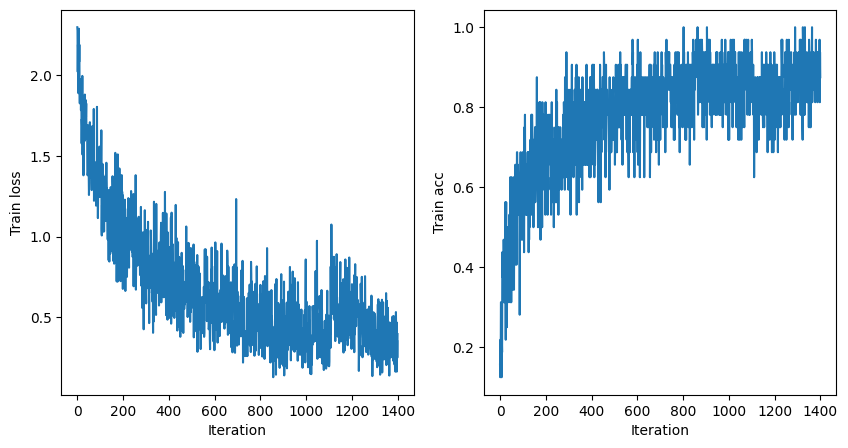

In [ ]:
train_audio_clfr(
    rnn_mel,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
)

Посчитаем метрики на валидационном датасете.

Val accuracy: 0.8085561497326204


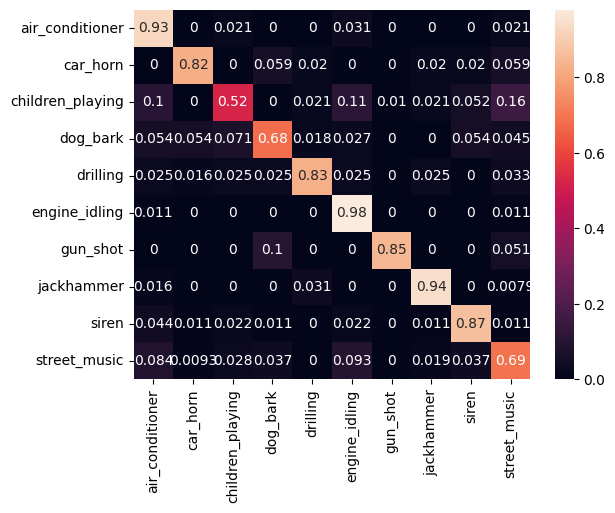

In [ ]:
plot_confusion_matrix(
    rnn_mel,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)

Сравним со сверточной сетью

In [ ]:
class CNN10(nn.Module):
    def __init__(self, num_classes=10, hidden=16):
        super().__init__()

        self.cnn_backbone = nn.Sequential(

            nn.Conv2d(1, 16, kernel_size=(3,3)),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 16, kernel_size=(3,3)),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=(3,3)),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, kernel_size=(3,3)),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=(3,3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=(3,3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=(3,3)),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=(2,2)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.final_mlp = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x, lens):
        z = self.cnn_backbone(x[:, None, :, :])
        z = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
        return self.final_mlp(z)

In [ ]:
cnn = CNN10()
cnn.to(device)

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 19


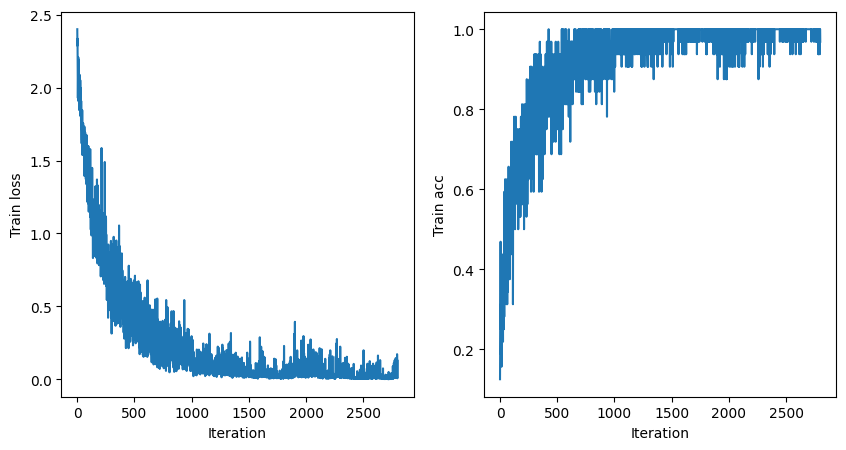

In [ ]:
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    num_epochs=20,
)

Val accuracy: 0.8898395721925134


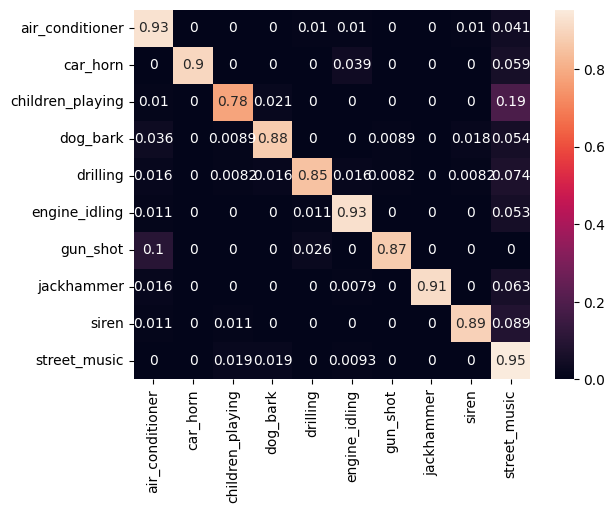

In [ ]:
plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)

Сделаем аугментации данных


In [ ]:
import random


class SpectAugment:
    def __init__(
        self,
        filling_value="mean",
        n_freq_masks=2,
        n_time_masks=2,
        max_freq=10,
        max_time=50,
    ):

        self.filling_value = filling_value
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.max_freq = max_freq
        self.max_time = max_time

    def __call__(self, spect, lens):
        sp_copy = spect.clone()

        for id, elem in enumerate(sp_copy):
            for step in range(self.n_freq_masks):
                f_eps = np.random.randint(0, self.max_freq)
                f = np.random.randint(0, elem.shape[0] - f_eps)

                if self.filling_value == 'max':
                    elem[f:f + f_eps, :] = torch.max(elem)
                elif self.filling_value == 'mean':
                    elem[f:f + f_eps, :] = torch.mean(elem)
                elif self.filling_value == 'v':
                    elem[f:f + f_eps, :] = np.random.randint(torch.min(elem), torch.max(elem))
                elif self.filling_value == 'min':
                    elem[f:f + f_eps, :] = torch.min(elem)

            for step in range(self.n_time_masks):
                t_eps = random.randint(0, min(self.max_time, lens[id]))
                t = random.randint(0, lens[id] - t_eps)

                if self.filling_value == 'mean':
                    elem[:, t:t + t_eps] = torch.mean(elem)
                elif self.filling_value == 'min':
                    elem[:, t:t + t_eps] = torch.min(elem)
                elif self.filling_value == 'max':
                    elem[:, t:t + t_eps] = torch.max(elem)
                elif self.filling_value == 'v':
                    elem[:, t:t + t_eps] = np.random.randint(torch.min(elem), torch.max(elem))

        return sp_copy, lens

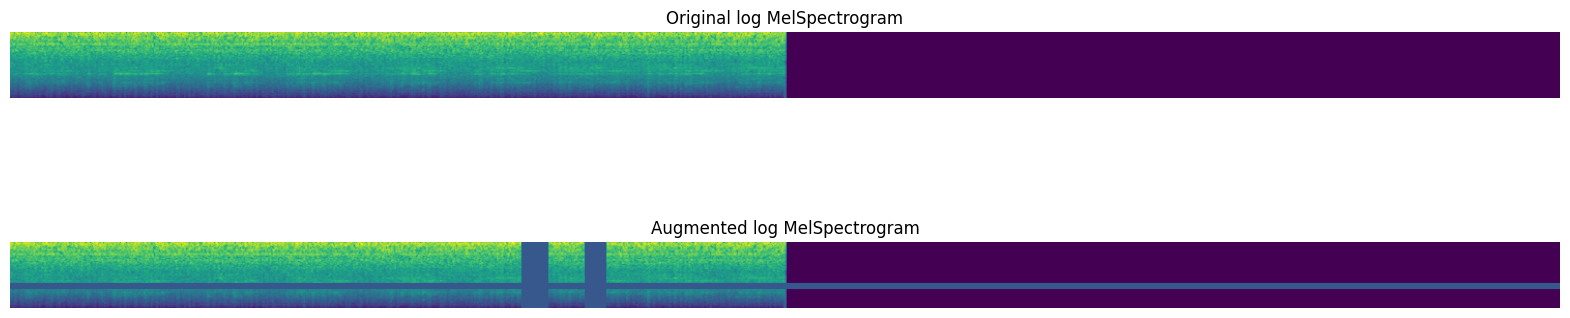

In [ ]:
# применим аугментацию к данным
for batch in train_dataloader:
    break

x = batch["x"].to(device)
lens = batch["len"].to(device)
x_logmel, lens = compute_log_melspectrogram_reference(
    x, lens, sr=train_dataset.sr, device=device
)
x_logmel_augmented, lens = SpectAugment()(x_logmel, lens)

# нарисуем спектрограмму до и после аугментации
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.title("Original log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel[0].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title("Augmented log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel_augmented[0].cpu().numpy())

plt.show()

In [ ]:
cnn = CNN10()
cnn.to(device)

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 19


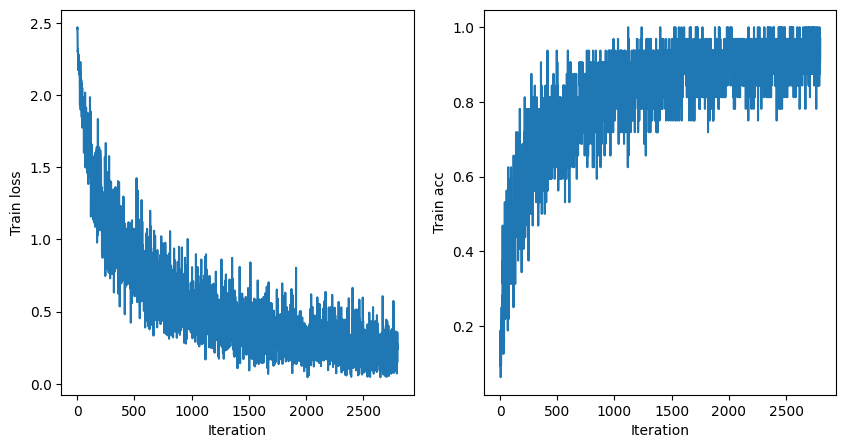

In [ ]:
# обучим модель на данных с аугментациями
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    augmentation=SpectAugment(),
    num_epochs=20,
)

Val accuracy: 0.906951871657754


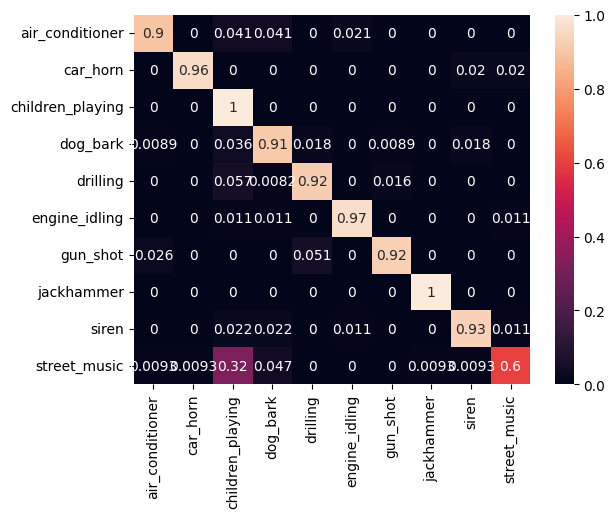

In [ ]:
plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)